In [1]:
import cv2
import pandas as pd
import numpy as np
import imutils
from scipy.spatial import distance as dist
from imutils import perspective
from imutils import contours
from imageProcessing import resizeImg, generateMask
import joblib
import tqdm

%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
# load the model from disk
filename = 'models/histgrad_model.sav'
loaded_model = joblib.load(filename)

In [131]:
def midpoint(ptA, ptB):
	return ((ptA[0] + ptB[0]) * 0.5, (ptA[1] + ptB[1]) * 0.5)

def resizeImg(path):
    img = cv2.imread(path) 
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    max_val = 640
    w, h, channels = img.shape
    if h > 640 or w > 640:
        if h >= w:
            new_h = max_val
            new_w = (new_h/h)*w

        else:
            new_w = max_val
            new_h = (new_w/w)*h
            
        img = cv2.resize(img, (int(new_h), int(new_w)))
    
    return img

def getFeats(img,numfeats = 65):
    try:
        fft = np.log10(np.abs(np.fft.fft2(img)))
        w = fft.shape[0]//2
        fft = fft[3:w+3,3:w+3]
        feats = fft[:numfeats,:numfeats]
        q = np.hstack(feats)
        if len(q) != numfeats*numfeats:
            plt.imshow(img)
            print("Invalid face to get features")
            return None
        return q
    except:
        print("Cannot extract features")
        return None

def checkPicture(img):
    #img = cv2.imread(path) 
    #img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # Generate a mask
    print(" Generating mask...")
    mask = generateMask(img)
    background_mask = np.all(mask == [0, 0, 0], axis=-1)
    #imarr = np.array(img)
    # Apply Mask / Separate Foreground and Background 
    foreground = np.array(img)
    foreground[background_mask] = [0,0,0]
    plt.figure(figsize=(8,12))
    #plt.subplot(1,2,1)
    #plt.imshow(foreground,cmap="gray")
    
    img_bw = cv2.cvtColor(foreground, cv2.COLOR_RGB2GRAY)
    img_bw = cv2.GaussianBlur(img_bw, (7, 7), 1)
    
    res = loaded_model.predict([getFeats(img_bw)])
    
    '''
    img_bw = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    res = loaded_model.predict([getFeats(img_bw)])
    '''
    print("Validation result -->",res[0])
    
    return res[0],img,img_bw

def findFace(img_bw):
    faceCascade = cv2.CascadeClassifier(cv2.data.haarcascades + "haarcascade_frontalface_alt2.xml")
    faces = faceCascade.detectMultiScale(
        img_bw,
        scaleFactor=1.3,
        minNeighbors=3,
        minSize=(30, 30)
    )
    
    if len(faces) == 0:
        print ("Face not found")
        return 0
    else:
        min_area = 0
        for (x, y, w, h) in faces:
            face_area = w*h
            if face_area > min_area:
                face = [x,y,w,h]
            #cv2.rectangle(img_bw, (x, y), (x + w, y + h), (0, 0, 255), 2)
        return face

def getContour(img_bw):
    edged = cv2.Canny(img_bw, 50, 100)
    edged = cv2.dilate(edged, None, iterations=1)
    edged = cv2.erode(edged, None, iterations=1)
    #plt.subplot(1,3,2)
    #plt.imshow(edged,cmap="gray")
    
    
    # find contours in the edge map
    cnts = cv2.findContours(edged.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnts = imutils.grab_contours(cnts)
    
    #Get all contours and select the biggest one.
    (cnts, _) = contours.sort_contours(cnts)
    lst=[]
    for ind,c in enumerate(cnts):
        lst.append([ind,cv2.contourArea(c)])
    lst.sort(key=lambda lst: lst[1], reverse=True)
    c = cnts[lst[0][0]]
    #print (c)
    return c
    
def getMeasures(img,c,face,altura):
    # Compute the bounding box of the contour
    orig = img.copy()
    
    #show the rectangle
    x, y, w, h = cv2.boundingRect(c)
    #cv2.rectangle(orig, (x, y), (x+w, y+h),(0, 255, 0), 2)
    box_points = [[x,y],[x,y+h],[x+w,y+h],[x+w,y]]
    new_box = np.array(box_points, dtype="int")
    #print(new_box)
    
    #show the face
    if face != 0:
        x, y, w, h = face
        cv2.rectangle(orig, (x, y), (x+w, y+h),(0, 0, 250), 2)
        face_points = [[x,y],[x,y+h],[x+w,y+h],[x+w,y]]
        face = np.array(face_points, dtype="int")
        #print(face)
    
    # loop over the original points and draw them
    #for (x, y) in new_box:
        #cv2.circle(orig, (int(x), int(y)), 5, (0, 0, 255), -1)
    
    
    # unpack the ordered bounding box, then compute the midpoint
    # between the top-left and top-right coordinates, followed by
    # the midpoint between bottom-left and bottom-right coordinates
    (tl,bl,br,tr) = new_box
    (trX,trY) = tr
    (brX,brY) = br
    (tlX,tlY) = tl
    (blX,blY) = bl
    (tltrX, tltrY) = midpoint(tl, tr)
    (blbrX, blbrY) = midpoint(bl, br)

    # compute the midpoint between the top-left and top-right points,
    # followed by the midpoint between the top-righ and bottom-right
    (tlblX, tlblY) = midpoint(tl, bl)
    (trbrX, trbrY) = midpoint(tr, br)

    # draw the midpoints on the image
    cv2.circle(orig, (int(tltrX), int(tltrY)), 5, (255, 0, 0), -1)
    cv2.circle(orig, (int(blbrX), int(blbrY)), 5, (255, 0, 0), -1)
    #cv2.circle(orig, (int(tlblX), int(tlblY)), 5, (255, 0, 0), -1)
    #cv2.circle(orig, (int(trbrX), int(trbrY)), 5, (255, 0, 0), -1)

    # draw lines to measure altura:
    cv2.line(orig, (int(tltrX),int(tltrY)),(int(tlX-10),int(tlY)),(255, 0, 0), 2)
    cv2.line(orig, (int(blbrX),int(blbrY)),(int(blX-10),int(blY)),(255, 0, 0), 2)
    cv2.line(orig, (int(tlX-10),int(tlY)),(int(blX-10),int(blY)),(255, 0, 0), 2)
    #cv2.line(orig, (int(tlblX), int(tlblY)), (int(trbrX), int(trbrY)),(255, 0, 0), 2)
   
    

    # compute the Euclidean distance between the midpoints
    dAltura = dist.euclidean((tltrX, tltrY), (blbrX, blbrY))
    dAncho = dist.euclidean((tlblX, tlblY), (trbrX, trbrY))
    
    
    # if the pixels per metric has not been initialized, then
    # compute it as the ratio of pixels to supplied metric
    #altura=120
    #altura = input("altura: ")
    pixelsPerMetric = dAltura / int(altura)

    # compute the size of the object
    dimAltura = dAltura / pixelsPerMetric
    max_ancho = dAncho / pixelsPerMetric
    
    # draw the object sizes on the image
    cv2.putText(orig,"{:.1f}".format(dimAltura),(int(tlX-80),int(tlY+200)),cv2.FONT_HERSHEY_SIMPLEX,0.7,(255,0,0),2)
    cv2.putText(orig,"cm",(int(tlX-55),int(tlY+220)),cv2.FONT_HERSHEY_SIMPLEX,0.7,(255,0,0),2)
    
    # show the output image
    #plt.subplot(1,2,2)
    plt.imshow(orig,cmap="gray")

    
def obtainMeasures(path,altura):
    print('Resizing image')
    img = resizeImg(path)
    print('Validating image')
    res,img,img_bw = checkPicture(img)
    
    if res == "OK":
        #print('Finding face')
        face = 0 #findFace(img_bw)
        c = getContour(img_bw)
        print('Getting measures')
        getMeasures(img,c,face,altura)

        return res
    else:
        print("The image is not valid.")
        

Resizing image
Validating image
 Generating mask...
 * -- Are you a person?
 * -- oooops... something went wrong
 * -- Just kidding...We are almost there!
Validation result --> OK
Getting measures


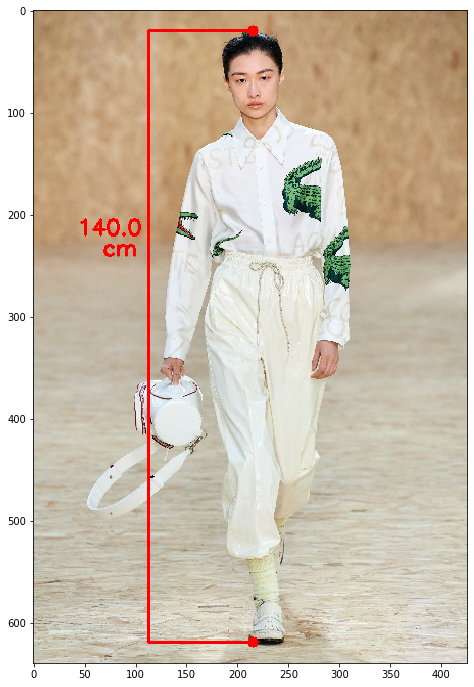

In [132]:
measure = obtainMeasures("../inputs/images/People_Yes_fullHD/OK_000008.jpg",140)

Resizing image
Validating image
 Generating mask...
 * -- Are you a person?
 * -- oooops... something went wrong
 * -- Just kidding...We are almost there!
Validation result --> OK
Getting measures


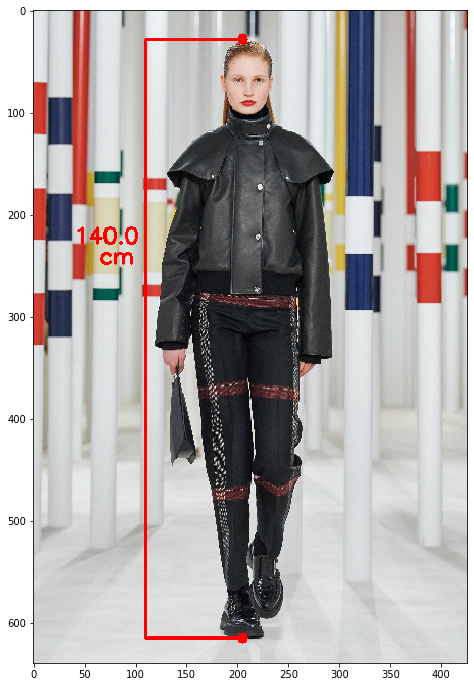

In [138]:
measure = obtainMeasures("../inputs/images/People_Yes_fullHD/OK_000305.jpg",140)

Resizing image
Validating image
 Generating mask...
 * -- Are you a person?
 * -- oooops... something went wrong
 * -- Just kidding...We are almost there!
Validation result --> OK
Getting measures


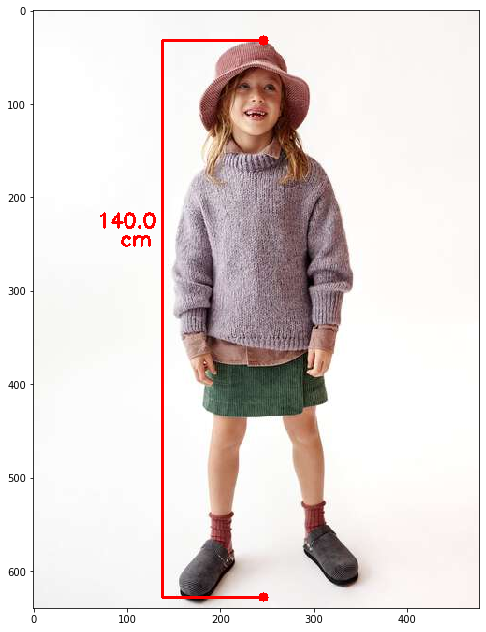

In [139]:
p="../inputs/images/Posture_Yes/modelo1.jpg"
measure = obtainMeasures(p,140)

In [140]:
p="../inputs/images/People_No/000000138954.jpg"
measure = obtainMeasures(p,140)

Resizing image
Validating image
 Generating mask...
 * -- Are you a person?
 * -- oooops... something went wrong
 * -- Just kidding...We are almost there!
Validation result --> KO
The image is not valid.


<Figure size 576x864 with 0 Axes>

Resizing image
Validating image
 Generating mask...
 * -- Are you a person?
 * -- oooops... something went wrong
 * -- Just kidding...We are almost there!
Validation result --> OK
Getting measures


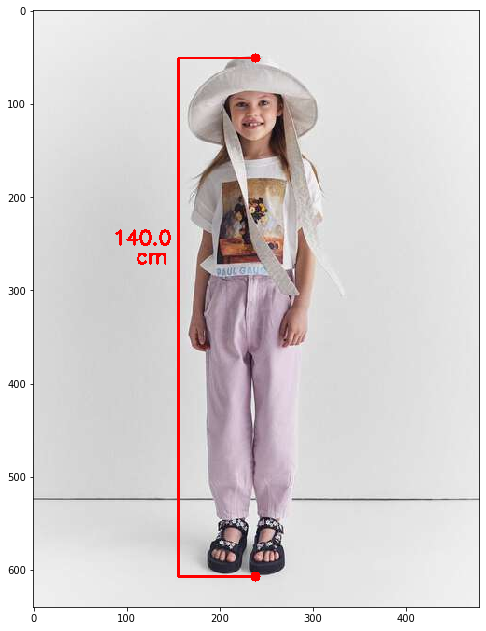

In [141]:
p="../inputs/images/Posture_Yes/modelo13.jpg"
measure = obtainMeasures(p,140)

In [24]:
from time import sleep
from tqdm import tqdm

for i in tqdm(range(10)):
    sleep(0.2)

100%|██████████| 10/10 [00:02<00:00,  4.89it/s]


In [ ]:
# import the necessary packages
from obtain_measures import *
import argparse
import cv2

# initialize the list of reference points and boolean indicating
# whether cropping is being performed or not
refPt = []
cropping = False
def click_and_crop(event, x, y, flags, param):
	# grab references to the global variables
	global refPt, cropping
	# if the left mouse button was clicked, record the starting
	# (x, y) coordinates and indicate that cropping is being
	# performed
	if event == cv2.EVENT_LBUTTONDOWN:
		refPt = [(x, y)]
		cropping = True
	# check to see if the left mouse button was released
	elif event == cv2.EVENT_LBUTTONUP:
		# record the ending (x, y) coordinates and indicate that
		# the cropping operation is finished
		refPt.append((x, y))
		cropping = False
		# draw a rectangle around the region of interest
		cv2.line(image, refPt[0], refPt[1], (0, 255, 0), 2)
		cv2.imshow("image", image)


# construct the argument parser and parse the arguments
ap = argparse.ArgumentParser()
ap.add_argument("-i", "--image", required=True, help="Path to the image")
ap.add_argument("-a", "--altura", required=True, help="altura en centimetros")
args = vars(ap.parse_args())

# load the image, clone it, and setup the mouse callback function
image = cv2.imread(args["image"])
altura = args["altura"]
clone = image.copy()
cv2.namedWindow("image")
cv2.setMouseCallback("image", click_and_crop)

# keep looping until the 'q' key is pressed
while True:
	# display the image and wait for a keypress
	cv2.imshow("image", image)
	key = cv2.waitKey(1) & 0xFF
	# if the 'r' key is pressed, reset the cropping region
	if key == ord("r"):
		image = clone.copy()
	# if the 'c' key is pressed, break from the loop
	elif key == ord("c"):
		break

# if there are two reference points, then crop the region of interest
# from teh image and display it
if len(refPt) == 2:
	roi = clone[refPt[0][1]:refPt[1][1], refPt[0][0]:refPt[1][0]]
	cv2.imshow("ROI", roi)
	cv2.waitKey(0)

#  close all open windows
cv2.destroyAllWindows()